# お薦め商品の提案（Association分析）

## 処理 Pattern と想定される業務利用 Sean
### Association 分析
- 大量の商品購入履歴 Data から「商品Ａと商品Ｂが同時に購入されることが多い」といった法則を見つけ出す分析手法。
- 「商品Ａと商品Ｂを Set にして割り引き価格を設定する」といった Marketing施策を導く
- 単価が少額の商品Ｘの仕入れを継続するか検討する時、分析の結果、高単価の商品Ｙと Set で売れており売上に貢献していることが判明。商品Ｘの仕入れを継続する判断を導く

## 教師なし学習（分析）の処理 Pattern
単に分析結果を出しただけでは、AI の効果がでたことにならない。
**得られた知見を基に、何か戦略を考え、その効果があって初めて分析の意味を持つ**

### 教師あり学習との違い
| 学習方法   | 特徴                                                                                           |
|--------|----------------------------------------------------------------------------------------------|
| 教師あり学習 | 正解 Data の収集が大変だが、Model構築までできれば業務での活用は比較的簡単なことが多い。                                            |
| 教師なし学習 | 正解 Data の収集は不要なので Model構築は比較的簡単。しかし、業務での活用は「知見を基に戦略を考え、それが効果を出す」と1 Action 余分に必要なので比較的難易度が高い。 |

## 例題の Data 説明と Use case

Data: UCI Dataset の「Online Retail Data Set 」（Online 小売り Data Set）を利用。
イギリスを拠点とし、Gift 商品を中心に販売している EC Site の取引履歴 Data
- 取引はまとまった単位で行なわれているので、一般顧客より小売業者が主な対象と考えられる。
- Data 件数は総数で 54万件
- 商品購買分析の例題でよく利用される Data.

この Data からフランスの顧客からよく Set 購入されていることが商品を見つけだす。

## Model の概要
Association分析で重要な概念
- 支持度（support）
- 確信度（confidence)
- Lift値（lift）

#### 支持度（support）
計算の出発点になる指標値。
**顧客全体の中で、今注目している商品を購入した顧客の比率**
S = A/n
S = B/n

#### 確信度（confidence）
Ａを買った人を全体とした時、そのうち何人がＢも一緒に購入したか
S(A&B) / S(A)

#### Lift値
S(A&B) / S(A)*S(B)
ＡとＢが独立な状態であれば Lift 値は１になる。逆に相関の関係があると Lift値は１より大きくなる。
Lift値が高ければ高いほどＡとＢの相関は強い、ということになる。

計算方法自体は、Simple だが実際には何万点、何十万点にも件数がなりえ、そうなると組み合わせの数が爆発して有限時間で計算できなくなる。
そこで、「**支持度の閾値**」という概念がでてくる。

### Association分析
1. 探索開始時に支持度（対象事象の購入比率の下限値）を定める。
2. この下限値より下の事象は、探索の対象から切り捨てる。（**アプリオリ分析**）
3. 抽出した商品List から確信度、または Lift値の高い Rule を抽出する。

購買履歴 -> アプリオリ分析（支持度で抽出）-> 商品List -> Rule抽出（Lift値 or 確信度で抽出）-> Association Rule

アプリオリ分析の仕掛けがあるので、対象商品が沢山あっても有限時間で計算できる。
一方、めったに売れない商品で支持度が低い場合、切り捨てられて、計算対象に入らなくなる。このため **「支持度の下限値」が Association分析で最も重要な Parameter** になる。

In [36]:
# 余分な Warning を非表示にする
import warnings

warnings.filterwarnings('ignore')

# Library の import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib に日本語化
import japanize_matplotlib

# DataFrame 表示用関数
from IPython.display import display

# Originals
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx
# 表示 Option 調整
# NumPy の浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandas での浮動小数点の表示速度
pd.options.display.float_format = '{:.4f}'.format
# DataFrame ですべての項目を表示
pd.set_option('display.max_columns', None)
# Graph の Default Font 指定
plt.rcParams['font.size'] = 14
# 乱数の種
random_seed = 123

## Data 読み込みから Data 確認まで

In [2]:
# Data の読み込み
# 公開 Data は Excel 形式なので、read_excel 関数で読み込む
# 時間がかなりかかるそうなので書籍では直接読み込んでいるが、File を一度 DL しそれを読み込むようにする
df = pd.read_excel('datasets/online_retail.xlsx')

# 項目名を日本語に変更
columns = [
    '発注番号', '商品番号', '商品説明', '商品個数', '明細書発行日', '商品単価', '顧客番号', '国名'
]
df.columns = columns

#### Data 確認

In [3]:
# Data 件数確認
print(df.shape[0])

# Data 内容確認
display(df.head())

541909


,発注番号,商品番号,商品説明,商品個数,明細書発行日,商品単価,顧客番号,国名
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [4]:
# 欠損値確認
print(df.isnull().sum())

発注番号           0
商品番号           0
商品説明        1454
商品個数           0
明細書発行日         0
商品単価           0
顧客番号      135080
国名             0
dtype: int64


欠損値の対応について
- 商品説明: 商品辞書を作成することで自動的に対応することになる。
- 顧客番号: 今回は顧客個別ではなく、発注単位の分析方針なので、このままで問題なし。

結論として、欠損値の対応は不要とす。

どの国の顧客からの注文が多いのか、国別の集計をとってみる

In [5]:
# 国名確認
print(df['国名'].value_counts().head(10))

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: 国名, dtype: int64


地元イギリス（United Kingdom）が圧倒的に多い。

## Data 前処理
次の３つの前処理を実施する
- 対象を新規 Order だけに限定
- 対象をフランスに限定
- Data を One-Hot 形式に変換（※Association分析固有の処理）

In [6]:
# 「発注種別」列の追加

# 前処理用に Data を Copy
df2 = df.copy()

# 発注番号の頭１桁を別項目に抽出
#(5: 新規 Order, C: Cansel)
df2['発注種別'] = df2['発注番号'].map(lambda x: str(x)[0])

# 結果確認
display(df2.head())

# 種別個数確認
print(df2['発注種別'].value_counts())

,発注番号,商品番号,商品説明,商品個数,明細書発行日,商品単価,顧客番号,国名,発注種別
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,5
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,5
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,5
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,5
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,5


5    532618
C      9288
A         3
Name: 発注種別, dtype: int64


In [7]:
# 新規 Order のみ抽出
df2 = df2[df2['発注種別']=='5']

# 件数確認
print(df2.shape[0])

532618


In [8]:
# 分析対象をフランスに限定する
df3 = df2[df2['国名']=='France']

# 件数確認
print(df3.shape[0])

8408


この Data を最終的な分析対象とする。

### Data を One-Hot 形式化
「Association分析では、横持ち形式の入力 Data が必要なため発注番号」「商品番号」の「縦持ちと」呼ばれる形で表現している Data を商品ごとの列を持つ「横持ち」と呼ばれる形式に変換する。

In [9]:
# # 発注番号と商品番号を Key に商品個数を集計する
w1 = df3.groupby(['発注番号', '商品番号'])['商品個数'].sum()

# 結果確認
print(w1.head())

発注番号    商品番号 
536370  10002    48
        21035    18
        21724    12
        21731    24
        21791    24
Name: 商品個数, dtype: int64


In [10]:
# 商品番号を列に移動（unstack 関数の利用）
w2 = w1.unstack().reset_index().fillna(0).set_index('発注番号')

# Size 確認
print(w2.shape)

# 結果確認
display(w2.head())

(392, 1542)


商品番号     10002  10120  10125  10135  11001  15036  15039  16012  16048  16218  \
発注番号                                                                            
536370 48.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

商品番号    16219  16225  16236  16237   16238  17174  20615  20617  20658  20665  \
発注番号                                                                            
536370 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 28.0000 0.0000 0.0000 0.0000 0.0000 6.0000   
537463 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

商品番号    20668  20674  20675  20676  20677  20679  20681  20682  20684  20685  \
発注番号                                                                           
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 6.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 6.0000 6.0000 0.0000 0.0000   

商品番号    20686  20702  20704  20711  20712  20713  20717  20718   20719  20723  \
発注番号                                                                            
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 10.0000 0.0000   

商品番号    20724   20725   20726  20727   20728  20749  20750  20751  20767  \
発注番号                                                                       
536370 0.0000  0.0000  0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000  0.0000  0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 10.0000 10.0000 0.0000  0.0000 2.0000 2.0000 0.0000 0.0000   
537065 0.0000 10.0000 20.0000 0.0000 10.0000 2.0000 6.0000 0.0000 0.0000   
537463 0.0000  0.0000  0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000   

商品番号    20777  20819  20832  20866  20914  20961  20963  20966  20967  20971  \
発注番号                                                                           
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

商品番号    20972  20973  20974  20975  20977  20978  20979  20981  20983  20984  \
発注番号                                                                           
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

商品番号    20992  20996  21003  21012  21026  21027  21030  21034   21035  21039  \

DataFrame では２段階の Index を持つ形式状態で `unstack()` 関数を利用すると簡単に行Index の列Indexへの移動が可能。

In [11]:
# 集計結果が正か０かで True/False を設定
basket_df = w2.apply(lambda x: x>0)

# 結果確認
display(basket_df.head())

商品番号    10002  10120  10125  10135  11001  15036  15039  16012  16048  16218  \
発注番号                                                                           
536370   True  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

商品番号    16219  16225  16236  16237  16238  17174  20615  20617  20658  20665  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False   True  False  False  False  False   True   
537463  False  False  False  False  False  False  False  False  False  False   

商品番号    20668  20674  20675  20676  20677  20679  20681  20682  20684  20685  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False   True  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False   True   True  False  False   

商品番号    20686  20702  20704  20711  20712  20713  20717  20718  20719  20723  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False   True  False   

商品番号    20724  20725  20726  20727  20728  20749  20750  20751  20767  20777  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False   True   True  False  False   True   True  False  False  False   
537065  False   True   True  False   True   True   True  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

商品番号    20819  20832  20866  20914  20961  20963  20966  20967  20971  20972  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

商品番号    20973  20974  20975  20977  20978  20979  20981  20983  20984  20992  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

商品番号    20996  21003  21012  21026  21027  21030  21034  21035  21039  21

DataFrame の `apply()` 関数を利用して簡潔に実装できる

「教師なし学習」には、Data 分割の Step が存在しない。それが「教師あり学習」と最大の相違点。

### 商品名辞書の準備
商品番号と商品名の対応表を作成する

In [12]:
# Data 件数再確認
print(df.shape[0])

# Data 内容再確認
df.head()

541909


,発注番号,商品番号,商品説明,商品個数,明細書発行日,商品単価,顧客番号,国名
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


「商品説明」の欄に商品名が含まれている。この情報を手がかりに商品名辞書を作成する

In [13]:
# 「商品番号」と「商品説明」のみを抽出
w3 = df2[['商品番号', '商品説明']].drop_duplicates()

# 商品番号と商品名をすべて文字列に変換
w3['商品番号'] = w3['商品番号'].astype('str')
w3['商品説明'] = w3['商品説明'].astype('str')

# 商品番号を Index に
w3 = w3.set_index('商品番号')
display(w3.head())

,商品説明
商品番号,
85123A,WHITE HANGING HEART T-LIGHT HOLDER
71053,WHITE METAL LANTERN
84406B,CREAM CUPID HEARTS COAT HANGER
84029G,KNITTED UNION FLAG HOT WATER BOTTLE
84029E,RED WOOLLY HOTTIE WHITE HEART.


In [14]:
# 冒頭の５個の商品Code 抽出
item_list1 = w3.index[:5]

# w3 に対する検索結果
display(w3.loc[item_list1])

,商品説明
商品番号,
85123A,WHITE HANGING HEART T-LIGHT HOLDER
85123A,?
85123A,wrongly marked carton 22804
85123A,CREAM HANGING HEART T-LIGHT HOLDER
71053,WHITE METAL LANTERN
71053,WHITE MOROCCAN METAL LANTERN
84406B,CREAM CUPID HEARTS COAT HANGER
84406B,incorrectly made-thrown away.
84406B,?


すべての文字が大文字だと商品名になっている様子。
そのような条件で絞り込みをかけてみる。

In [15]:
# 大文字だけの Text 抽出

# 作業用に Copy
w4 = w3.copy()

# すべての大文字名称の行のみ残す
w4 = w4[w4['商品説明'].map(lambda x: x.isupper())]

# 先ほど作った `item_list1` で結果確認
display(w4.loc[item_list1])

,商品説明
商品番号,
85123A,WHITE HANGING HEART T-LIGHT HOLDER
85123A,CREAM HANGING HEART T-LIGHT HOLDER
71053,WHITE METAL LANTERN
71053,WHITE MOROCCAN METAL LANTERN
84406B,CREAM CUPID HEARTS COAT HANGER
84029G,KNITTED UNION FLAG HOT WATER BOTTLE
84029E,RED WOOLLY HOTTIE WHITE HEART.


まだ同じ商品で名前が２通りあるものが見られる。１つの商品番号に複数の説明が対応した場合、１番長い文字列を選ぶ方針でさらに絞り込む

In [16]:
# １番長い名称の抽出

# 作業用に copy
w5 = w4.copy()

# 「文字数」列の追加
w5['文字数'] = w5['商品説明'].map(len)

# Sort
w5 = w5.sort_values(['商品番号', '文字数'], ascending=[True, False])

# 商品ごとに１番長い名称を抽出して item_dict に代入
item_dict = w5.groupby('商品番号')['商品説明'].agg(lambda x: x[0])

# 先ほど作った item_list1 で結果確認
print(item_dict.loc[item_list1])

商品番号
85123A     WHITE HANGING HEART T-LIGHT HOLDER
71053            WHITE MOROCCAN METAL LANTERN
84406B         CREAM CUPID HEARTS COAT HANGER
84029G    KNITTED UNION FLAG HOT WATER BOTTLE
84029E         RED WOOLLY HOTTIE WHITE HEART.
Name: 商品説明, dtype: object


## Algorithm の選択と分析

In [17]:
# Apriori による分析
freq_item1 = apriori(basket_df, min_support=0.06, use_colnames=True)

# 結果確認
display(freq_item1.sort_values('support', ascending=False).head(10))

# itemset 数確認
print(freq_item1.shape[0])

,support,itemsets
61,0.7653,(POST)
52,0.1888,(23084)
14,0.1811,(21731)
37,0.1709,(22554)
39,0.1684,(22556)
114,0.1658,"(POST, 23084)"
24,0.1582,(22326)
82,0.1582,"(POST, 21731)"
4,0.1531,(20725)
89,0.1480,"(POST, 22326)"


134


商品あるいは商品の組み合わせのそれぞれに対して「支持度（support）」を算出し、この値が閾値（0.06）より大きいものだけを抽出。
134件の商品またはその組み合わせが検出されました。

In [18]:
# Association Rule の抽出
a_rules1 = association_rules(freq_item1, metric="lift", min_threshold=1)

# Lift値で sort
a_rules1 = a_rules1.sort_values('lift', ascending=False).reset_index(drop=True)

# 結果確認
display(a_rules1.head(10))
# Rule数確認
print(a_rules1.shape[0])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(23254),(23256),0.0714,0.0689,0.0638,0.8929,12.9630,0.0589,8.6905
1,(23256),(23254),0.0689,0.0714,0.0638,0.9259,12.9630,0.0589,12.5357
2,(22727),"(22728, 22726)",0.0944,0.0740,0.0638,0.6757,9.1333,0.0568,2.8552
3,"(22728, 22726)",(22727),0.0740,0.0944,0.0638,0.8621,9.1333,0.0568,6.5657
4,(22727),"(POST, 22726)",0.0944,0.0842,0.0714,0.7568,8.9894,0.0635,3.7650
5,"(POST, 22726)",(22727),0.0842,0.0944,0.0714,0.8485,8.9894,0.0635,5.9770
6,(22726),"(22728, 22727)",0.0969,0.0740,0.0638,0.6579,8.8929,0.0566,2.7068
7,"(22728, 22727)",(22726),0.0740,0.0969,0.0638,0.8621,8.8929,0.0566,6.5472
8,(22727),(22726),0.0944,0.0969,0.0791,0.8378,8.6430,0.0699,5.5689
9,(22726),(22727),0.0969,0.0944,0.0791,0.8158,8.6430,0.0699,4.9162


206


「Lift値が１以上」という条件で Rule抽出を行なう。
- 商品番号「23254」と「23256」
- 商品番号「22726」「22727」[22728」の間に強い関係が予想される。

商品名辞書`item_dict`を使用して商品名を調べる。

In [19]:
# 関係性の高い商品の商品Code を list up
item_list = ['23254', '23256', '22726', '22727', '22728']

# 商品名を確認
for item in item_list:
    print(item, item_dict[item])

23254 CHILDRENS CUTLERY DOLLY GIRL 
23256 CHILDRENS CUTLERY SPACEBOY 
22726 ALARM CLOCK BAKELIKE GREEN
22727 ALARM CLOCK BAKELIKE RED 
22728 ALARM CLOCK BAKELIKE PINK


- 「23254」と「23256」: 女の子向けと男の向けの食器Set
- 「22726」「22727」「22728」: 同じ Series の色違いの目覚まし時計

と判明。
商店が商品を仕入れる時に、Set購入しているのではないかと予想される。

今回の判明した知見に基づいた戦略の例として関係性の強い商品を Set販売として割引する、などが考えられる。

## Tuning
`min_support`の値だけ 0.06 から 0.065 に少しだけ増やして再分析してみる

In [20]:
# Apriori による分析
freq_item2 = apriori(basket_df, min_support=0.065, use_colnames=True)

# Association Rule の抽出
a_rules2 = association_rules(freq_item2, metric='lift', min_threshold=1)

# Lift値で sort
a_rules2 = a_rules2.sort_values('lift', ascending=False).reset_index(drop=True)

# 結果確認
display(a_rules2.head(10))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(22727),"(POST, 22726)",0.0944,0.0842,0.0714,0.7568,8.9894,0.0635,3.7650
1,"(POST, 22726)",(22727),0.0842,0.0944,0.0714,0.8485,8.9894,0.0635,5.9770
2,(22727),(22726),0.0944,0.0969,0.0791,0.8378,8.6430,0.0699,5.5689
3,(22726),(22727),0.0969,0.0944,0.0791,0.8158,8.6430,0.0699,4.9162
4,(22726),"(POST, 22727)",0.0969,0.0867,0.0714,0.7368,8.4954,0.0630,3.4704
5,"(POST, 22727)",(22726),0.0867,0.0969,0.0714,0.8235,8.4954,0.0630,5.1173
6,"(22728, POST)",(22727),0.0893,0.0944,0.0663,0.7429,7.8703,0.0579,3.5218
7,(22727),"(22728, POST)",0.0944,0.0893,0.0663,0.7027,7.8703,0.0579,3.0633
8,(22728),(22727),0.1020,0.0944,0.0740,0.7250,7.6811,0.0643,3.2931
9,(22727),(22728),0.0944,0.1020,0.0740,0.7838,7.6811,0.0643,4.1531


`a?rules1` の分析では No.1, 2 だった「23254」と「23256」の間の Association がなくなっている。
`freq_item1` と `freq_item2` 、２つの Apriori分析の結果から「23254」と「23256」を含む行を抽出して調べてみる。

In [24]:
# 調査対象の集合
t_set = set([23254, 23256])

# １回目の分析 freq_item1 から該当行を抽出
idx1 = freq_item1['itemsets'].map(lambda x: not x.isdisjoint(t_set))
item1 = freq_item1[idx1]

# ２回目の分析 freq_item2 から該当行を抽出
idx2 = freq_item2['itemsets'].map(lambda x: not x.isdisjoint(t_set))
item2 = freq_item2[idx2]

# 結果確認
display(item1)
display(item2)

,support,itemsets
58,0.0714,(23254)
59,0.0689,(23256)
118,0.0638,"(23256, 23254)"


,support,itemsets
53,0.0714,(23254)
54,0.0689,(23256)


`min_support` の値を0.005高くしたことで(23256, 23254) の条件度の支持度が含まれなくなっていることがわかる。

## 関係 Graph の視覚化
分析した Association Rule（商品間の関係性）を「関係 Graph」で確認してみる。

In [37]:
# 対象とする関係を上位20に限定
a = a_rules1.head(20)

# 親Node の抽出
ant = a['antecedents'].values
ant = [tuple(x) for x in ant]

# 子Node の抽出
con = a['consequents'].values
con = [tuple(x) for x in con]

# 全Node の Listup
both = ant + con
both = list(set(both))

# 結果の一部確認
print(both[:10])

[(22728, 'POST'), (22726, 22727), (21080, 21086), (22728, 22727), (23254,), (21094,), (22727,), (22728, 22726), (22726,), ('POST', 22727)]


In [40]:
# 関係 Graph の初期化
G = nx.DiGraph()

# Node の追加
for n in both:
    G.add_node(n)

# Edge の追加
for i in range(len(a)):
    item = a.loc[i]
    ant = tuple(item['antecedents'])
    con = tuple(item['consequents'])
    G.add_edge(ant, con)

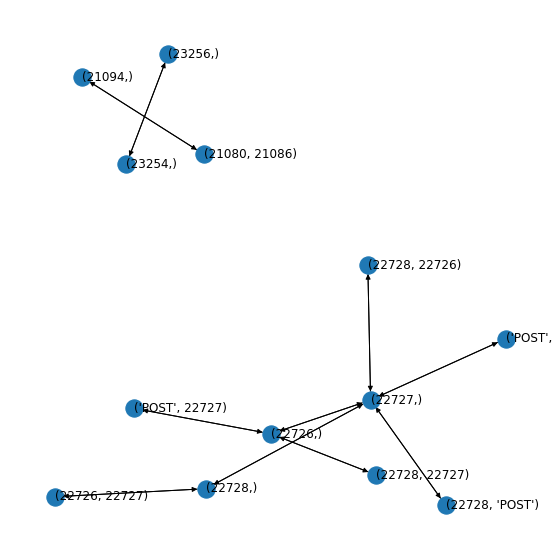

In [43]:
# Graph 描画
pos = nx.spring_layout(G, k=0.6, seed=random_seed)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, horizontalalignment='left', verticalalignment='center')
plt.axis('off')
plt.tight_layout()
plt.show()